In [ ]:
!pip install pycaret --quiet --upgrade
!pip install dabl --quiet --upgrade
!pip install shap --quiet --upgrade
!pip install sdv  --quiet --upgrade
!pip install sdv[ctgan] --quiet --upgrade
!pip install baytune --quiet --upgrade
!pip install optuna

# **Will they stay or will they go? Predicting employee attrition and improving models with synthetic data**
---

## **Why this was done**
1. Learn about synthetic data generation and see if it can improve a model
2. Work with PyCaret on a classification problem
3. Provide interpretation of the model(s) used so it can be known WHY a model is predicting A or B
4. Work on an HR related problem

## **The data**
HR data isn't easy to find given the nature of the data. However IBM has created [fictious data](https://www.kaggle.com/pavansubhasht/ibm-hr-analytics-attrition-dataset) around whether an employee left after 6 months which can be used. The features for each employee are...

* ` Age `
* ` Attrition `
* ` BusinessTravel `
* ` DailyRate `
* ` Department `
* ` DistanceFromHome `
* ` Education `
* ` EducationField `
* ` EmployeeCount `
* ` EmployeeNumber `
* ` EnvironmentSatisfaction `
* ` Gender `
* ` HourlyRate `
* ` JobInvolvement `
* ` JobLevel `
* ` JobRole `
* ` JobSatisfaction `
* ` MaritalStatus `
* ` MonthlyIncome `
* ` MonthlyRate `
* ` NumCompaniesWorked `
* ` Over18 `
* ` OverTime `
* ` PercentSalaryHike `
* ` PerformanceRating `
* ` RelationshipSatisfaction `
* ` StandardHours `
* ` StockOptionLevel `
* ` TotalWorkingYears `
* ` TrainingTimesLastYear `
* ` WorkLifeBalance `
* ` YearsAtCompany `
* ` YearsInCurrentRole `
* ` YearsSinceLastPromotion `
* ` YearsWithCurrManager `

# **The main problems**
When looking at employee data you may not have millions of employees. When  building a model often you need a lot of data. We have a potential problem of **not having enough data**.

Alongside not having a lot of data to model with, the majority of people will most likely not leave if the company is good. So in the data you'll have say 10% of employees left in 6 months and 90% stayed. This is an **imbalanced classification problem**

The solution to the problem - **generate synthetic data**

Why?
1. It captures the characteristics of the original data
2. If the small volume class is the only one generated then the imbalanced problem and data volume disappears
3. You train with the synthetic data but remove it when testing you still get reliable evaluation metrics

# **Libraries**

In [1]:
from pycaret.classification import * # Preprocessing, modelling, interpretation, deployment...
import pandas as pd # Basic data manipulation
import dabl as db # Summary plot
from sklearn.model_selection import train_test_split # Data split
from sdv.tabular import CopulaGAN # Synthetic data
from sdv.evaluation import evaluate # Evaluate synthetic data
from btb.tuning import Tunable, GCPTuner # CopulaGAN optimising
from btb.tuning import hyperparams as hp  # Set hyperparameters for optimising

# **Importing data**

In [3]:
# Read and output some of the data
hr_data = pd.read_csv("HR Employee Attrition.csv")
hr_data.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


# **Visualising**
As mentioned the main problem with this dataset is a large class imbalance for the target feature `Attrition`. I will model the data with the imbalance to see how it performs but there will be a way to improve it, synthetic data generation.

The other features look somewhat normal except for `StandardHours` and `EmployeeCount` which have zero variance hence will be ignored.

Target looks like classification


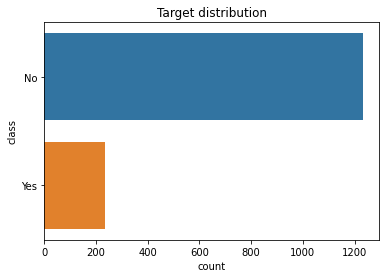

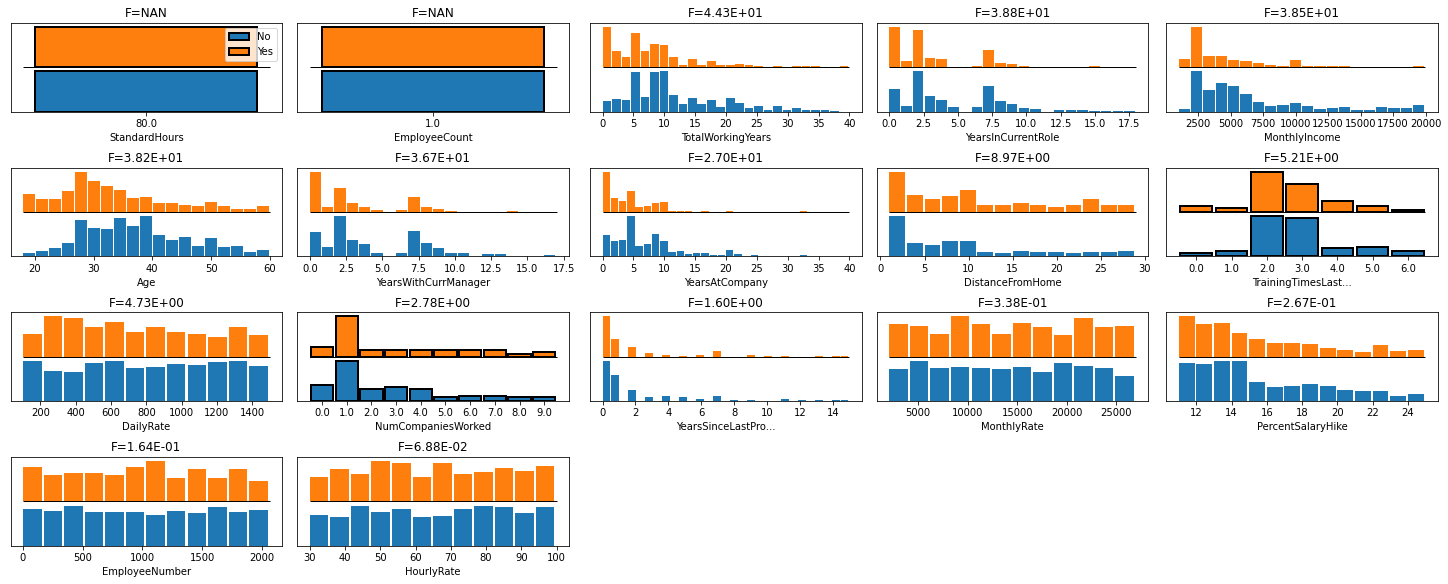

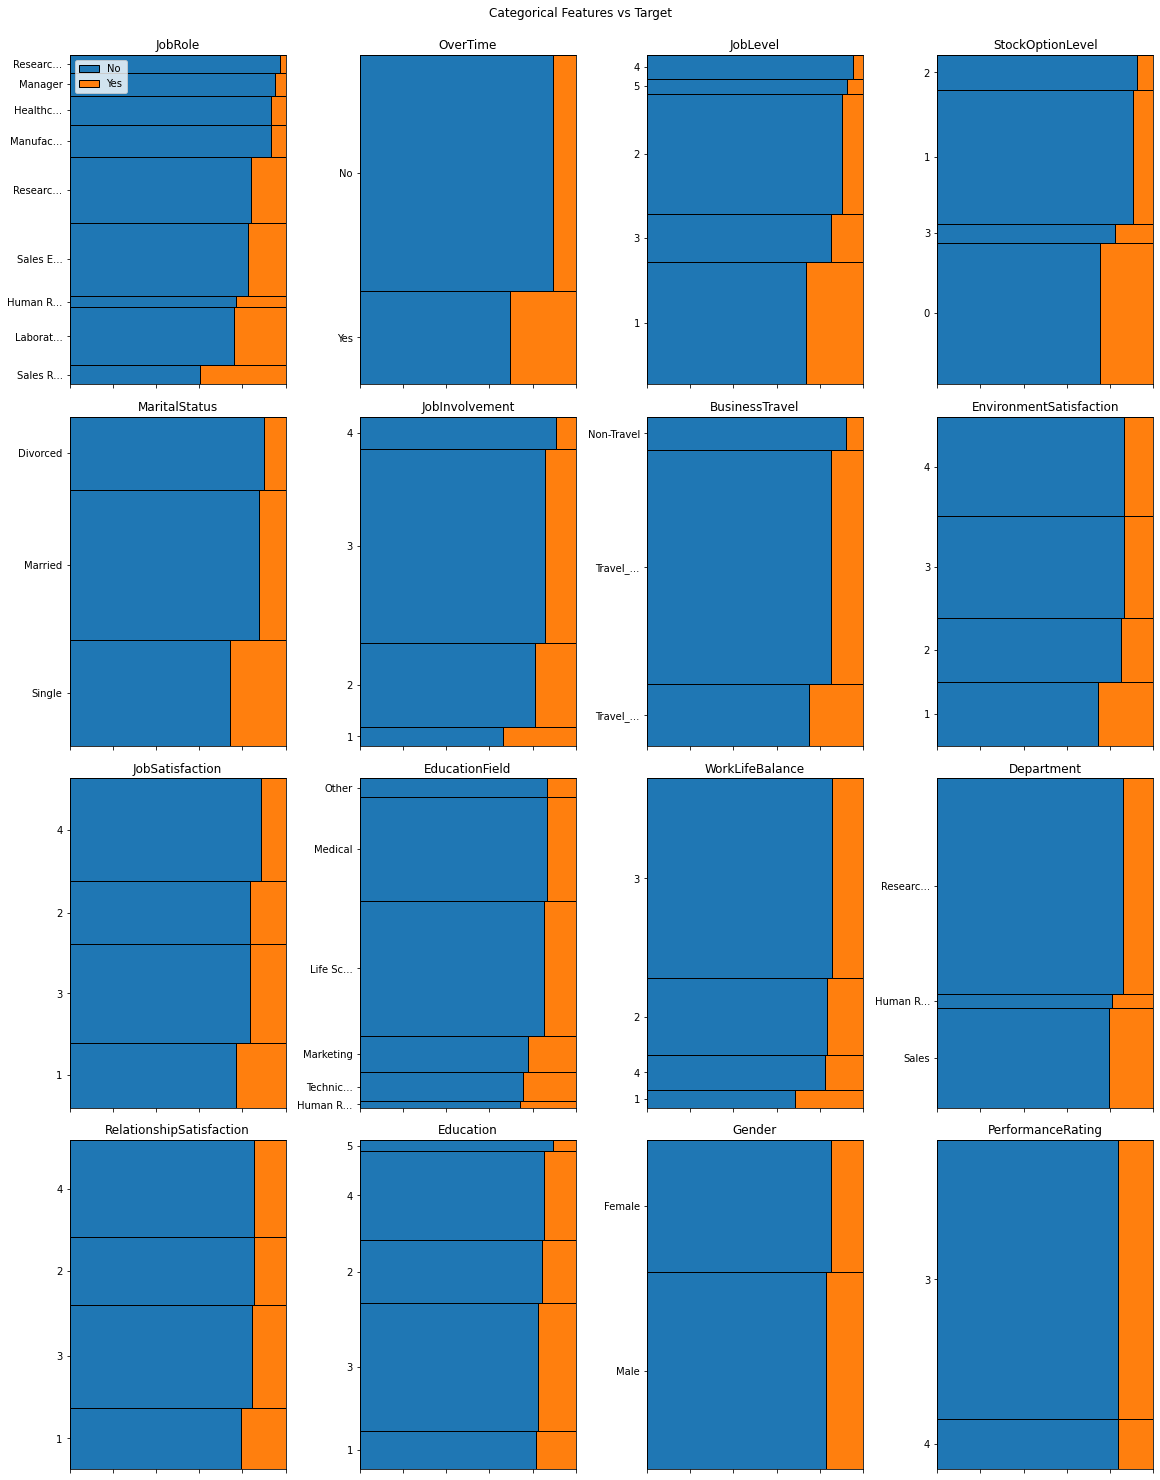

In [4]:
# Plot summaries of continuous + categorical features
## Type hints are used to force types on certain features
types = {"DistanceFromHome" : "continuous", "EmployeeCount" : "continuous",
         "HourlyRate" : "continuous", "MonthlyRate" : "continuous", 
         "NumCompaniesWorked" : "continuous", "PercentSalaryHike" : "continuous",
         "StandardHours" : "continuous", "TotalWorkingYears" : "continuous", 
         "YearsAtCompany" : "continuous", "YearsSinceLastPromotion" : "continuous",
         "YearsWithCurrManager" : "continuous", "TrainingTimesLastYear" : "continuous",
         "Age" : "continuous", "DailyRate" : "continuous", "MonthlyIncome" : "continuous"}

db.plot(hr_data, y = "Attrition", type_hints = types, plot_pairwise = False)

# **First modelling w/original data**
I'll use `Pycaret` to model the data given it's speed. It can handle a lot of the preprocessing, modelling, evaluation and interpretation. Given the dataset is ~1.5k rows the processing isn't too intensive but if it increased in size thankfully Pycaret has GPU functionality.

Ordinal features need to have their levels known and order which can quickly be done.

In [5]:
ord_levels = ['StockOptionLevel', 'EnvironmentSatisfaction', 'JobInvolvement', 'JobSatisfaction', 
              'Education', 'PerformanceRating', 'RelationshipSatisfaction', 'WorkLifeBalance']

for feat in ord_levels:
  print(feat, hr_data[feat].unique())

StockOptionLevel [0 1 3 2]
EnvironmentSatisfaction [2 3 4 1]
JobInvolvement [3 2 4 1]
JobSatisfaction [4 2 3 1]
Education [2 1 4 3 5]
PerformanceRating [3 4]
RelationshipSatisfaction [1 4 2 3]
WorkLifeBalance [1 3 2 4]


A fairly simply ordering per feature. Now feature(s) can be initialised
* Target feature
* Continuous features
* Ordinal features
* Categorical features
* Features to ignore

In [6]:
# Initialise appropriate features for pycaret

# Target feature
target = "Attrition"

# Continuous features
cont_feats = ["DistanceFromHome", "HourlyRate",  "DailyRate", "MonthlyIncome",
              "MonthlyRate", "NumCompaniesWorked", "PercentSalaryHike",
              "TotalWorkingYears", "YearsAtCompany",
              "YearsWithCurrManager", "TrainingTimesLastYear", "YearsSinceLastPromotion"]

# Ordinal features
ord_feats = {"StockOptionLevel" : ["0", "1", "2", "3"],
             "EnvironmentSatisfaction" : ["1", "2", "3", "4"],
             "JobInvolvement" : ["1", "2", "3", "4"],
             "JobSatisfaction" : ["1", "2", "3", "4"],
             "Education" : ["1", "2", "3", "4", "5"],
             "PerformanceRating" : ["3", "4"],
             "RelationshipSatisfaction" : ["1", "2", "3", "4"],
             "WorkLifeBalance" : ["1", "2", "3", "4"]}

# Categorical geatures
cat_feats = ["BusinessTravel", "Department", "EducationField", "JobRole",
             "Gender", "JobLevel", "JobRole", "Over18",
             "MaritalStatus", "OverTime", "WorkLifeBalance"]

# Features to ignore
ignore = ["EmployeeNumber", "StandardHours", "EmployeeCount"]

Now with the features initalised can be fed into pycaret's `setup` function.
* Feed in data + features
* Normalize continuous features + use `minimax` as the normalization method
* Use stratified k folding on the data
* Cross validation
* Remove features with low variance

There a lot on offer but not everything is used here.

In [ ]:
# Run pycaret setup
setup(hr_data, 
      target = target,
      train_size = 0.7, 
      numeric_features = cont_feats,
      categorical_features = cat_feats,
      ordinal_features = ord_feats,
      ignore_features = ignore,
      normalize = True,
      normalize_method = "minmax",
      data_split_stratify = True,
      ignore_low_variance = True,,
      silent = True, verbose = False)

Now it's "setup", I like to use `compare_models` to get a rough idea as to which model(s) might be best for this particular use case. The particular metrics I'm looking at are `AUC`, `Precision` and `Recall`. `Recall` is most important as we want to make sure we are correctly identifying the **true negatives** i.e. those that might leave in 6 months.

In [8]:
compare_models(sort = "AUC")

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.8736,0.8485,0.4232,0.6879,0.5141,0.4473,0.4695,0.326
lda,Linear Discriminant Analysis,0.8716,0.8396,0.4401,0.6680,0.5218,0.4523,0.4700,0.029
catboost,CatBoost Classifier,0.8658,0.8068,0.2173,0.8155,0.3366,0.2911,0.3723,2.315
ada,Ada Boost Classifier,0.8609,0.8048,0.3875,0.6095,0.4706,0.3961,0.4108,0.151
et,Extra Trees Classifier,0.8599,0.7998,0.1934,0.8350,0.3007,0.2559,0.3437,0.516
rf,Random Forest Classifier,0.8560,0.7977,0.1210,0.9250,0.2104,0.1807,0.2981,0.536
xgboost,Extreme Gradient Boosting,0.8531,0.7951,0.2897,0.5963,0.3842,0.3135,0.3420,5.218
lightgbm,Light Gradient Boosting Machine,0.8580,0.7927,0.2779,0.6504,0.3812,0.3172,0.3569,0.146
gbc,Gradient Boosting Classifier,0.8638,0.7893,0.3085,0.6775,0.4147,0.3519,0.3903,0.279
knn,K Neighbors Classifier,0.8395,0.6484,0.1213,0.5095,0.1905,0.1403,0.1856,0.120


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=2199, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

So `Logistic Regression` is looking promising so I'll build a model on this. As shown below each fold's metrics are shown and the average.

In [9]:
lr = create_model("lr")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8835,0.8748,0.5294,0.6923,0.6000,0.5332,0.5398
1,0.8641,0.8844,0.3529,0.6667,0.4615,0.3921,0.4181
2,0.8252,0.7832,0.2353,0.4444,0.3077,0.2184,0.2329
3,0.8641,0.8249,0.4706,0.6154,0.5333,0.4554,0.4611
4,0.8835,0.7674,0.3529,0.8571,0.5000,0.4467,0.5034
5,0.8932,0.9015,0.3529,1.0000,0.5217,0.4767,0.5594
6,0.9126,0.9016,0.6250,0.7692,0.6897,0.6394,0.6441
7,0.8447,0.7845,0.3125,0.5000,0.3846,0.3011,0.3120
8,0.8824,0.8525,0.5000,0.6667,0.5714,0.5049,0.5119
9,0.8824,0.9099,0.5000,0.6667,0.5714,0.5049,0.5119


Some hyperparameter tuning may help improve the model a bit so I'll use `tune_model` and focus on `AUC`. I'm using the `optuna` library and searching using `tpe` searching algorithm.

Overall there doesn't seem like much improvement.

In [12]:
tune_model(lr, optimize = "AUC", n_iter = 100, search_library = "optuna", search_algorithm = "tpe",)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8835,0.8782,0.5294,0.6923,0.6000,0.5332,0.5398
1,0.8641,0.8865,0.3529,0.6667,0.4615,0.3921,0.4181
2,0.8447,0.7866,0.2353,0.5714,0.3333,0.2623,0.2956
3,0.8641,0.8235,0.4706,0.6154,0.5333,0.4554,0.4611
4,0.8835,0.7640,0.3529,0.8571,0.5000,0.4467,0.5034
5,0.8932,0.8988,0.3529,1.0000,0.5217,0.4767,0.5594
6,0.9126,0.9001,0.5000,0.8889,0.6400,0.5947,0.6266
7,0.8447,0.7859,0.3125,0.5000,0.3846,0.3011,0.3120
8,0.8824,0.8525,0.5000,0.6667,0.5714,0.5049,0.5119
9,0.8824,0.9106,0.5000,0.6667,0.5714,0.5049,0.5119


LogisticRegression(C=0.6853528417855729, class_weight={}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=2199, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

# **How to solve this problem**
So the model being used isn't the best. Hyperparameter tuning saw a small improvement but very minimal.

The area that I don't see being explored to improve models is **generating synthetic data**. There's talk about getting more data but what if you can't? **GENERATE IT**.

The problem is making sure the data generated shares characteristics as the original data.  

# **Second modelling w/original + synthetic data**

In [ ]:
tuner = GCPTuner(Tunable({
          'epochs': hp.IntHyperParam(min = 25, max = 400),
          'batch_size' : hp.IntHyperParam(min = 1, max = 100, include_min = True, include_max = True),
          'embedding_dim' : hp.IntHyperParam(min = 1, max = 200, include_min = True, include_max = True),
          'gen' : hp.IntHyperParam(min = 1, max = 500),
          'dim_gen' : hp.IntHyperParam(min = 1, max = 500)
        }))

In [ ]:
best_score = 0

real = hr_data[hr_data["Attrition"] == "Yes"]

for _ in range(50):
  proposal = tuner.propose(1)
  print(proposal)
  model = CopulaGAN(embedding_dim = proposal['embedding_dim'],
                    gen_dim = (proposal['gen'], proposal['gen']),
                    dis_dim = (proposal['dim_gen'], proposal['dim_gen']),
                    batch_size = proposal['batch_size'] * 10,
                    epochs = proposal['epochs'],
                    primary_key = "EmployeeNumber", 
                    field_transformers = {"BusinessTravel" : "categorical",
                                          "EducationField" : "categorical",
                                          "Department" : "categorical",
                                          "MaritalStatus" : "categorical",
                                          "JobRole" : "categorical",
                                          "Gender" : "categorical",
                                          "Over18" : "categorical",
                                          "OverTime" : "categorical"})
  model.fit(real)
  synth_data = model.sample(600, max_retries = 300)
  score = evaluate(synthetic_data = synth_data, real_data = real)
  print(score)
  if score > best_score:
    best_params = proposal
    best_score = score
        
  tuner.record(proposal, score)
    
print('Best score obtained: ', best_score)
print('Best parameters: ', best_params)

In [ ]:
{'epochs': 154, 'batch_size': 78, 'embedding_dim': 11, 'gen': 29, 'dim_gen': 237}

In [ ]:
for feat in list(ord_feats.keys()):
  print(input[feat].unique())

[3 2 0 1 4]
[3 1 4 2 0]
[3 1 4 2]
[2 3 4 1 0 5]
[2 4 1 3 5]
[3 4 5]
[3 2 4 1 5 0]
[2 4 3 1]


In [ ]:
# Insert synthetic data into real dataset and randomly split it
hr_data["dataset"] = "real"
synth_data["dataset"] = "synth"

full_data = pd.concat([hr_data, synth_data])

X_train, X_test, y_train, y_test = train_test_split(hr_data.drop("Attrition", axis = 1), hr_data["Attrition"], test_size=0.33, random_state=42)

X_train["Attrition"] = y_train
X_test["Attrition"] = y_test

input = pd.concat([X_train, synth_data]).drop("dataset", axis = 1)
test = X_test.drop("dataset", axis = 1)

In [ ]:
# Run pycaret setup
setup(input, 
      target = target, 
      test_data = test,
      transformation = True,
      train_size = 0.7, pca = True,
      numeric_features = cont_feats,
      categorical_features = cat_feats,
      ordinal_features = ord_feats,
      ignore_features = ignore,
      normalize = True,
      normalize_method = "robust",
      data_split_stratify = True,
      ignore_low_variance = True,
      silent = True)

In [ ]:
compare_models(sort = "AUC")

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.8777,0.9448,0.8298,0.9123,0.8431,0.7527,0.7719,9.325
et,Extra Trees Classifier,0.8853,0.9441,0.8246,0.9285,0.8451,0.7676,0.7873,0.497
qda,Quadratic Discriminant Analysis,0.8715,0.9424,0.8441,0.8744,0.8368,0.7402,0.7559,0.016
xgboost,Extreme Gradient Boosting,0.8708,0.9420,0.8324,0.8852,0.8375,0.7389,0.7534,5.146
gbc,Gradient Boosting Classifier,0.8702,0.9399,0.8233,0.8957,0.8345,0.7375,0.7543,1.158
lightgbm,Light Gradient Boosting Machine,0.8777,0.9387,0.8323,0.8995,0.8449,0.7528,0.7672,0.391
rf,Random Forest Classifier,0.8657,0.9359,0.8194,0.8919,0.8282,0.7286,0.7462,0.788
lr,Logistic Regression,0.8587,0.9334,0.8348,0.8711,0.8435,0.7161,0.7258,0.230
lda,Linear Discriminant Analysis,0.8631,0.9326,0.8309,0.8821,0.8436,0.7246,0.7367,0.020
nb,Naive Bayes,0.8537,0.9249,0.8023,0.8701,0.8163,0.7045,0.7154,0.015


In [ ]:
et = create_model("et")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6478,0.7458,0.2857,0.9565,0.4400,0.2795,0.3886
1,0.6415,0.8010,0.3117,0.8571,0.4571,0.2681,0.3449
2,0.9182,0.9678,0.8701,0.9571,0.9116,0.8359,0.8391
3,0.9497,0.9888,0.9610,0.9367,0.9487,0.8994,0.8996
4,0.9430,0.9801,0.9481,0.9359,0.9419,0.8860,0.8861
5,0.9684,0.9960,0.9610,0.9737,0.9673,0.9366,0.9367
6,0.9367,0.9862,0.9610,0.9136,0.9367,0.8735,0.8746
7,0.9430,0.9855,0.9868,0.9036,0.9434,0.8863,0.8898
8,0.9557,0.9967,0.9868,0.9259,0.9554,0.9115,0.9133
9,0.9494,0.9927,0.9737,0.9250,0.9487,0.8988,0.8999


In [ ]:
tune_model(et, optimize = "Recall")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6667,0.7922,0.3247,0.9615,0.4854,0.3189,0.4222
1,0.6415,0.7672,0.3506,0.7941,0.4865,0.2699,0.3233
2,0.9245,0.9804,0.8701,0.9710,0.9178,0.8484,0.8528
3,0.9560,0.9927,0.9740,0.9375,0.9554,0.9120,0.9126
4,0.9177,0.9769,0.9351,0.9000,0.9172,0.8355,0.8361
5,0.9747,0.9949,0.9870,0.9620,0.9744,0.9494,0.9497
6,0.9241,0.9849,0.9481,0.9012,0.9241,0.8482,0.8493
7,0.8987,0.9804,0.9737,0.8409,0.9024,0.7983,0.8076
8,0.9494,0.9926,1.0000,0.9048,0.9500,0.8990,0.9036
9,0.9304,0.9894,0.9605,0.9012,0.9299,0.8609,0.8626


ExtraTreesClassifier(bootstrap=True, ccp_alpha=0.0,
                     class_weight='balanced_subsample', criterion='gini',
                     max_depth=7, max_features='sqrt', max_leaf_nodes=None,
                     max_samples=None, min_impurity_decrease=0,
                     min_impurity_split=None, min_samples_leaf=2,
                     min_samples_split=7, min_weight_fraction_leaf=0.0,
                     n_estimators=270, n_jobs=-1, oob_score=False,
                     random_state=5823, verbose=0, warm_start=False)

In [ ]:
# Predict on unseen results and double check
unseen_results = predict_model(et, data = test.drop("Attrition", axis = 1))
unseen_results["actual"] = test["Attrition"]

In [ ]:
unseen_results["actual"] = test["Attrition"]

In [ ]:
unseen_results.shape

(486, 34)

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score

precision_score(unseen_results["actual"], unseen_results["Label"], labels = ["Yes", "No"], pos_label = "No"), recall_score(unseen_results["actual"], unseen_results["Label"], labels = ["Yes", "No"], pos_label = "No")

(0.8949771689497716, 0.9423076923076923)

# FASTAI

In [ ]:
X = get_config("X")
Y = get_config("y")
X["target"] = Y

In [ ]:
!pip install fastai --upgrade

In [ ]:
from fastai.tabular.all import *

In [ ]:
cat, cont = cont_cat_split(X, dep_var = "target")
splits = RandomSplitter()(range_of(X))

In [ ]:
X['target'] = X['target'].astype(str)

In [ ]:
to = TabularPandas(X, procs = [Categorify, Normalize], cat_names = cat, cont_names = cont, 
                   y_names = "target", splits = splits, y_block = CategoryBlock())

In [ ]:
dls = to.dataloaders(bs = 6)

In [ ]:
del learn

In [ ]:
learn = tabular_learner(dls, metrics = [accuracy, RocAucBinary(), Precision(), Recall()])

SuggestedLRs(lr_min=0.0015848932787775993, lr_steep=0.3019951581954956)

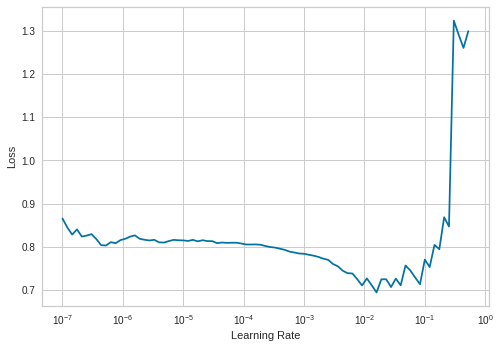

In [ ]:
learn.lr_find()

In [ ]:
learn.fine_tune(10, 5e-3)

epoch,train_loss,valid_loss,accuracy,roc_auc_score,precision_score,recall_score,time
0,0.465865,0.776532,0.830508,0.497449,0.000000,0.000000,00:04


epoch,train_loss,valid_loss,accuracy,roc_auc_score,precision_score,recall_score,time
0,0.323373,0.628975,0.830508,0.497449,0.000000,0.000000,00:04
1,0.212172,0.593734,0.830508,0.502551,0.000000,0.000000,00:04
2,0.205524,0.914700,0.830508,0.497449,0.000000,0.000000,00:04
3,0.190716,0.780756,0.830508,0.502551,0.000000,0.000000,00:04
4,0.167379,0.955354,0.830508,0.502551,0.000000,0.000000,00:04
5,0.095870,0.966577,0.830508,0.502551,0.000000,0.000000,00:04
6,0.040892,1.393632,0.830508,0.502551,0.000000,0.000000,00:04
7,0.021438,1.204639,0.830508,0.502551,0.000000,0.000000,00:04
8,0.017399,1.349500,0.830508,0.502551,0.000000,0.000000,00:04
9,0.004320,1.310108,0.830508,0.502551,0.000000,0.000000,00:04
